# 1. Install Dependencies and Setup

In [1]:
!pip install tensorflow opencv-python matplotlib

Defaulting to user installation because normal site-packages is not writeable
  Using cached packaging-24.1-py3-none-any.whl.metadata (3.2 kB)
  Using cached six-1.16.0-py2.py3-none-any.whl.metadata (1.8 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached pygments-2.18.0-py3-none-any.whl.metadata (2.5 kB)
   ---------------------------------------- 0.0/385.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/385.2 MB ? eta -:--:--
   ---------------------------------------- 0.3/385.2 MB ? eta -:--:--
   ---------------------------------------- 0.5/385.2 MB 932.9 kB/s eta 0:06:53
   ---------------------------------------- 0.8/385.2 MB 1.1 MB/s eta 0:05:44
   ---------------------------------------- 0.8/385.2 MB 1.1 MB/s eta 0:05:44
   ---------------------------------------- 1.0/385.2 MB 1.0 MB/s eta 0:06:07
   ---------------------------------------- 1.3/385.2 MB 1.1 MB/s eta 0:05:49
   ------------------------------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress t

In [1]:
!pip list

Package                 Version
----------------------- -----------
absl-py                 2.1.0
astunparse              1.6.3
certifi                 2024.8.30
charset-normalizer      3.3.2
contourpy               1.3.0
cycler                  0.12.1
flatbuffers             24.3.25
fonttools               4.54.1
gast                    0.6.0
google-pasta            0.2.0
grpcio                  1.66.1
h5py                    3.11.0
idna                    3.10
keras                   3.5.0
kiwisolver              1.4.7
libclang                18.1.1
Markdown                3.7
markdown-it-py          3.0.0
MarkupSafe              2.1.5
matplotlib              3.9.2
mdurl                   0.1.2
ml-dtypes               0.4.1
namex                   0.0.8
numpy                   1.26.4
opencv-python           4.10.0.84
opt-einsum              3.3.0
optree                  0.12.1
packaging               24.1
pillow                  10.4.0
pip                     24.2
protobuf           

In [3]:
import tensorflow as tf
import os

In [10]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [18]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable


# 2. Remove dodgy images

In [13]:
import cv2
import imghdr

In [14]:
data_dir = 'data' 

In [15]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [16]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [21]:
import numpy as np
from matplotlib import pyplot as plt

In [22]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [23]:
data_iterator = data.as_numpy_iterator()

In [24]:
batch = data_iterator.next()

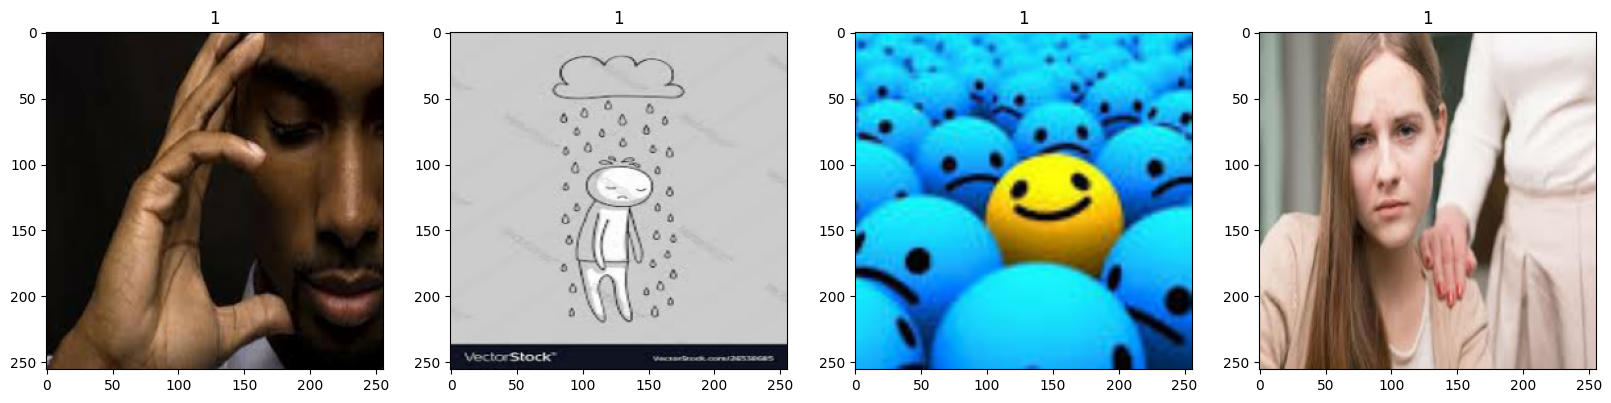

In [25]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [26]:
data = data.map(lambda x,y: (x/255, y))

In [27]:
data.as_numpy_iterator().next()

(array([[[[0.49116114, 0.30292585, 0.15390626],
          [0.5161382 , 0.3293505 , 0.17984834],
          [0.53574604, 0.35927543, 0.20633425],
          ...,
          [0.29391083, 0.21940105, 0.23508732],
          [0.24307598, 0.16856618, 0.18425246],
          [0.27682292, 0.20231311, 0.21799938]],
 
         [[0.52402365, 0.33578834, 0.18676874],
          [0.53643703, 0.3496493 , 0.20014717],
          [0.5396765 , 0.3632059 , 0.21026474],
          ...,
          [0.31105575, 0.23791249, 0.25314325],
          [0.27530074, 0.20663461, 0.22037299],
          [0.31227103, 0.23803453, 0.2536297 ]],
 
         [[0.55457395, 0.36633867, 0.21731906],
          [0.5559251 , 0.36913744, 0.21936762],
          [0.54332685, 0.3668563 , 0.21173987],
          ...,
          [0.33759516, 0.26831484, 0.2823323 ],
          [0.32296026, 0.26012284, 0.27223626],
          [0.3591628 , 0.2883092 , 0.30279163]],
 
         ...,
 
         [[0.47971773, 0.39954004, 0.33287334],
          [0.51652

# 5. Split Data

In [28]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [29]:
train_size

7

In [30]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [31]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [33]:
model = Sequential()

In [34]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

C:\Users\aashh\OneDrive\Desktop\Machine Learning\ImageClassification\imageclassification\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [35]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [36]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# 7. Train

In [37]:
logdir='logs'

In [38]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [39]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 520ms/step - accuracy: 0.4479 - loss: 1.2029 - val_accuracy: 0.5156 - val_loss: 0.6874
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 568ms/step - accuracy: 0.5279 - loss: 0.6898 - val_accuracy: 0.6406 - val_loss: 0.6656
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 449ms/step - accuracy: 0.6612 - loss: 0.6594 - val_accuracy: 0.7188 - val_loss: 0.5543
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 515ms/step - accuracy: 0.6765 - loss: 0.5833 - val_accuracy: 0.7031 - val_loss: 0.5684
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 507ms/step - accuracy: 0.7109 - loss: 0.5518 - val_accuracy: 0.7969 - val_loss: 0.5428
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 589ms/step - accuracy: 0.7717 - loss: 0.5189 - val_accuracy: 0.9219 - val_loss: 0.2780
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 562ms/step - accuracy: 0.7940 - loss: 0.4560 - val_accuracy: 0.8906 - val_loss: 0.3383
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 583ms/step - accuracy: 0.7939 - loss: 0.4037 - val_accuracy: 0.8594 - val_loss:

# 8. Plot Performance

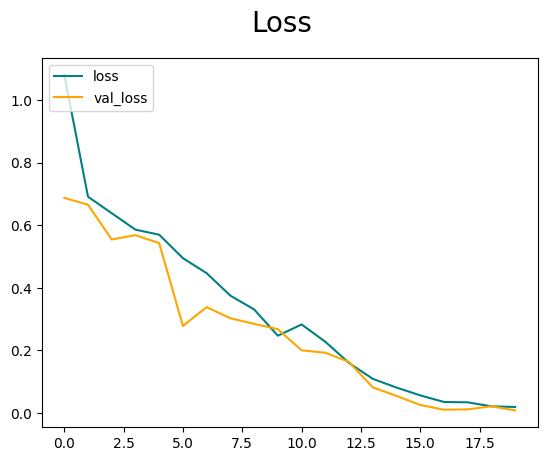

In [40]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

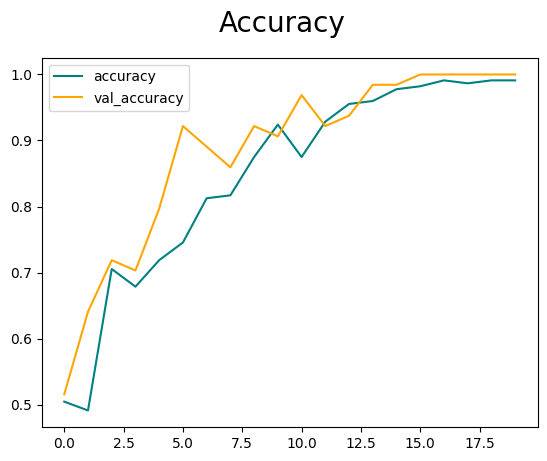

In [41]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [42]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [43]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [44]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


In [45]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [48]:
import cv2

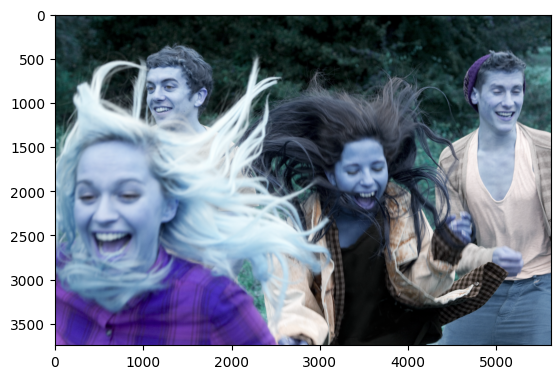

In [49]:
img = cv2.imread('154006829.jpg')
plt.imshow(img)
plt.show()

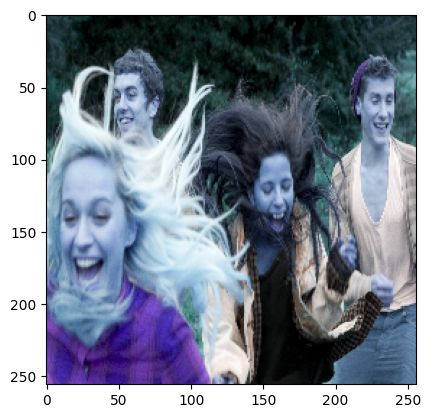

In [50]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [51]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


In [52]:
yhat

array([[0.02459927]], dtype=float32)

In [53]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


# 11. Save the Model

In [54]:
from tensorflow.keras.models import load_model

In [58]:
model.save(os.path.join('models','imageclassifier.keras'))

In [61]:
new_model = load_model(os.path.join('models','imageclassifier.keras'))

C:\Users\aashh\OneDrive\Desktop\Machine Learning\ImageClassification\imageclassification\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [62]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


array([[0.02459927]], dtype=float32)

In [64]:
yhatnew = new_model.predict(np.expand_dims(resize/255,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


In [65]:
if yhatnew > 0.5:
    print(f'predicted class is Sad')
else:
    print(f'predicted class is Happy')

predicted class is Happy
